In [1]:
import tensorflow as tf

from datasets import dataset_factory
from deployment import model_deploy
from nets import nets_factory
from preprocessing import preprocessing_factory
import matplotlib.pyplot as plt

slim = tf.contrib.slim

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np
import cv2
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
slim = tf.contrib.slim
checkpoint_file = '../data/MSCNN/log_HBPNet/model.ckpt-60000'
model_name = 'vgg_16'
num_classes = 100
image_size = 448

In [31]:
image_raw_data = tf.gfile.FastGFile("../data/images/0062258.jpg", 'r').read()
with tf.Graph().as_default() as graph:
    image_data = tf.image.decode_jpeg(image_raw_data)
    image = tf.expand_dims(image_data, axis=0)
    if image.dtype != tf.float32:
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)     
    image = tf.image.resize_images(image,[image_size, image_size])
    image.set_shape([1,image_size,image_size,3])

    network_fn = nets_factory.get_network_fn(
        model_name,
        num_classes=num_classes,
        is_training=False)
    logits, end_points = network_fn(image)
        
    variables_to_restore = slim.get_variables_to_restore(include=['vgg_16'])

    saver = tf.train.Saver(variables_to_restore)
    def restore_fn(sess):
        return saver.restore(sess, checkpoint_file)

    sv = tf.train.Supervisor(logdir = None, summary_op = None, init_fn = restore_fn)

    with sv.managed_session() as sess:
        raw_images, my_matrix = sess.run([image, end_points['vgg_16/hbp_part/bilinear_p2']])

    print raw_images.shape, my_matrix.shape

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ../data/MSCNN/log_HBPNet/model.ckpt-60000
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
(1, 448, 448, 3) (1, 28, 28, 8192)


In [32]:
import cv2
def gray2rgb(x):
    img = np.zeros((image_size,image_size,3))
    for i in range(3):
        img[:,:,i] = cv2.resize(x, (image_size,image_size))
    return img
def norm(a):
    a_max, a_min = a.max(), a.min()
    a = (a - a_min)/(a_max - a_min)
    return a

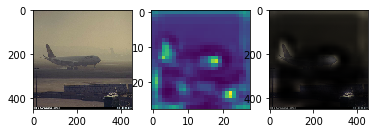

In [33]:
import numpy as np
plt.subplot(1,3,1)
plt.imshow(raw_images[0,:,:,:])
plt.subplot(1,3,2)
mean_img = np.mean(my_matrix[0,:,:,:],2)
plt.imshow(mean_img)
extract_img = gray2rgb(norm(mean_img)) * raw_images[0,:,:,:]
plt.subplot(1,3,3)
plt.imshow(extract_img)
plt.show()